'['SPY', 'QQQ', 'EFA', 'EEM', 'SSO', 'TQQQ', 'TLT', 'IEF', 'SHY', 'GLD', 'DBC', 'BTC-USD', 'ETH-USD', 'XRP-USD']' 종목 데이터 다운로드 시도 중...


[*********************100%***********************]  14 of 14 completed


수정 종가 데이터가 로컬에 저장되었습니다: /Users/012oov/Documents/Quant/MPT_Back/Data/Raw data/downloaded_stock_prices.csv

--- 'Max Calmar Ratio' 모델 동적 백테스팅 시작 ---
2018-12-31: 가중치 재계산 중...
2019-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were ou

2020-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


2021-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


2024-12-31: 가중치 재계산 중...

--- 'Max Sharpe Ratio' 모델 동적 백테스팅 시작 ---
2018-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


2019-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were ou

2020-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


2021-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were ou

2024-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



--- 'Risk Parity' 모델 동적 백테스팅 시작 ---
2018-12-31: 가중치 재계산 중...
2019-12-31: 가중치 재계산 중...
2020-12-31: 가중치 재계산 중...
2021-12-31: 가중치 재계산 중...
2024-12-31: 가중치 재계산 중...

--- 'Minimum Variance' 모델 동적 백테스팅 시작 ---
2018-12-31: 가중치 재계산 중...
2019-12-31: 가중치 재계산 중...
2020-12-31: 가중치 재계산 중...
2021-12-31: 가중치 재계산 중...
2024-12-31: 가중치 재계산 중...

--- 'Target Return (return%)' 모델 동적 백테스팅 시작 ---
2018-12-31: 가중치 재계산 중...
2019-12-31: 가중치 재계산 중...
2020-12-31: 가중치 재계산 중...
2021-12-31: 가중치 재계산 중...
2024-12-31: 가중치 재계산 중...


/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/012oov/Documents/Quant/MPT_Back/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "




--- 최종 성과 요약 ---
  - Max Calmar Ratio: CAGR=11.73%, MDD=-55.38%, Sharpe=0.44, Calmar=0.21
  - Max Sharpe Ratio: CAGR=5.34%, MDD=-22.99%, Sharpe=0.48, Calmar=0.23
  - Risk Parity: CAGR=6.03%, MDD=-13.32%, Sharpe=1.12, Calmar=0.45
  - Minimum Variance: CAGR=5.94%, MDD=-16.70%, Sharpe=0.94, Calmar=0.36
  - Target Return (return%): CAGR=12.42%, MDD=-22.65%, Sharpe=0.96, Calmar=0.55
  - Benchmark (SPY): CAGR=14.00%, MDD=-33.72%, Sharpe=0.71, Calmar=0.42
  - Benchmark (BTC-USD): CAGR=46.17%, MDD=-83.04%, Sharpe=0.68, Calmar=0.56

상세 성과 보고서가 저장되었습니다: /Users/012oov/Documents/Quant/MPT_Back/Results/performance_report.csv


,CAGR,Annualized Volatility,MDD,Sharpe Ratio,Calmar Ratio,Final Value
Model,,,,,,
Max Calmar Ratio,0.117307,0.263865,-0.553795,0.444572,0.211824,2.343240e+08
Max Sharpe Ratio,0.053390,0.110821,-0.229878,0.481772,0.232255,1.490791e+08
Risk Parity,0.060268,0.053687,-0.133239,1.122579,0.452329,1.567160e+08
Minimum Variance,0.059401,0.062870,-0.166953,0.944827,0.355795,1.557353e+08
Target Return (return%),0.124191,0.129595,-0.226496,0.958302,0.548315,2.456387e+08
Benchmark (SPY),0.139999,0.197153,-0.337173,0.710101,0.415213,2.732501e+08
Benchmark (BTC-USD),0.461678,0.678896,-0.830363,0.680041,0.555995,1.705782e+09


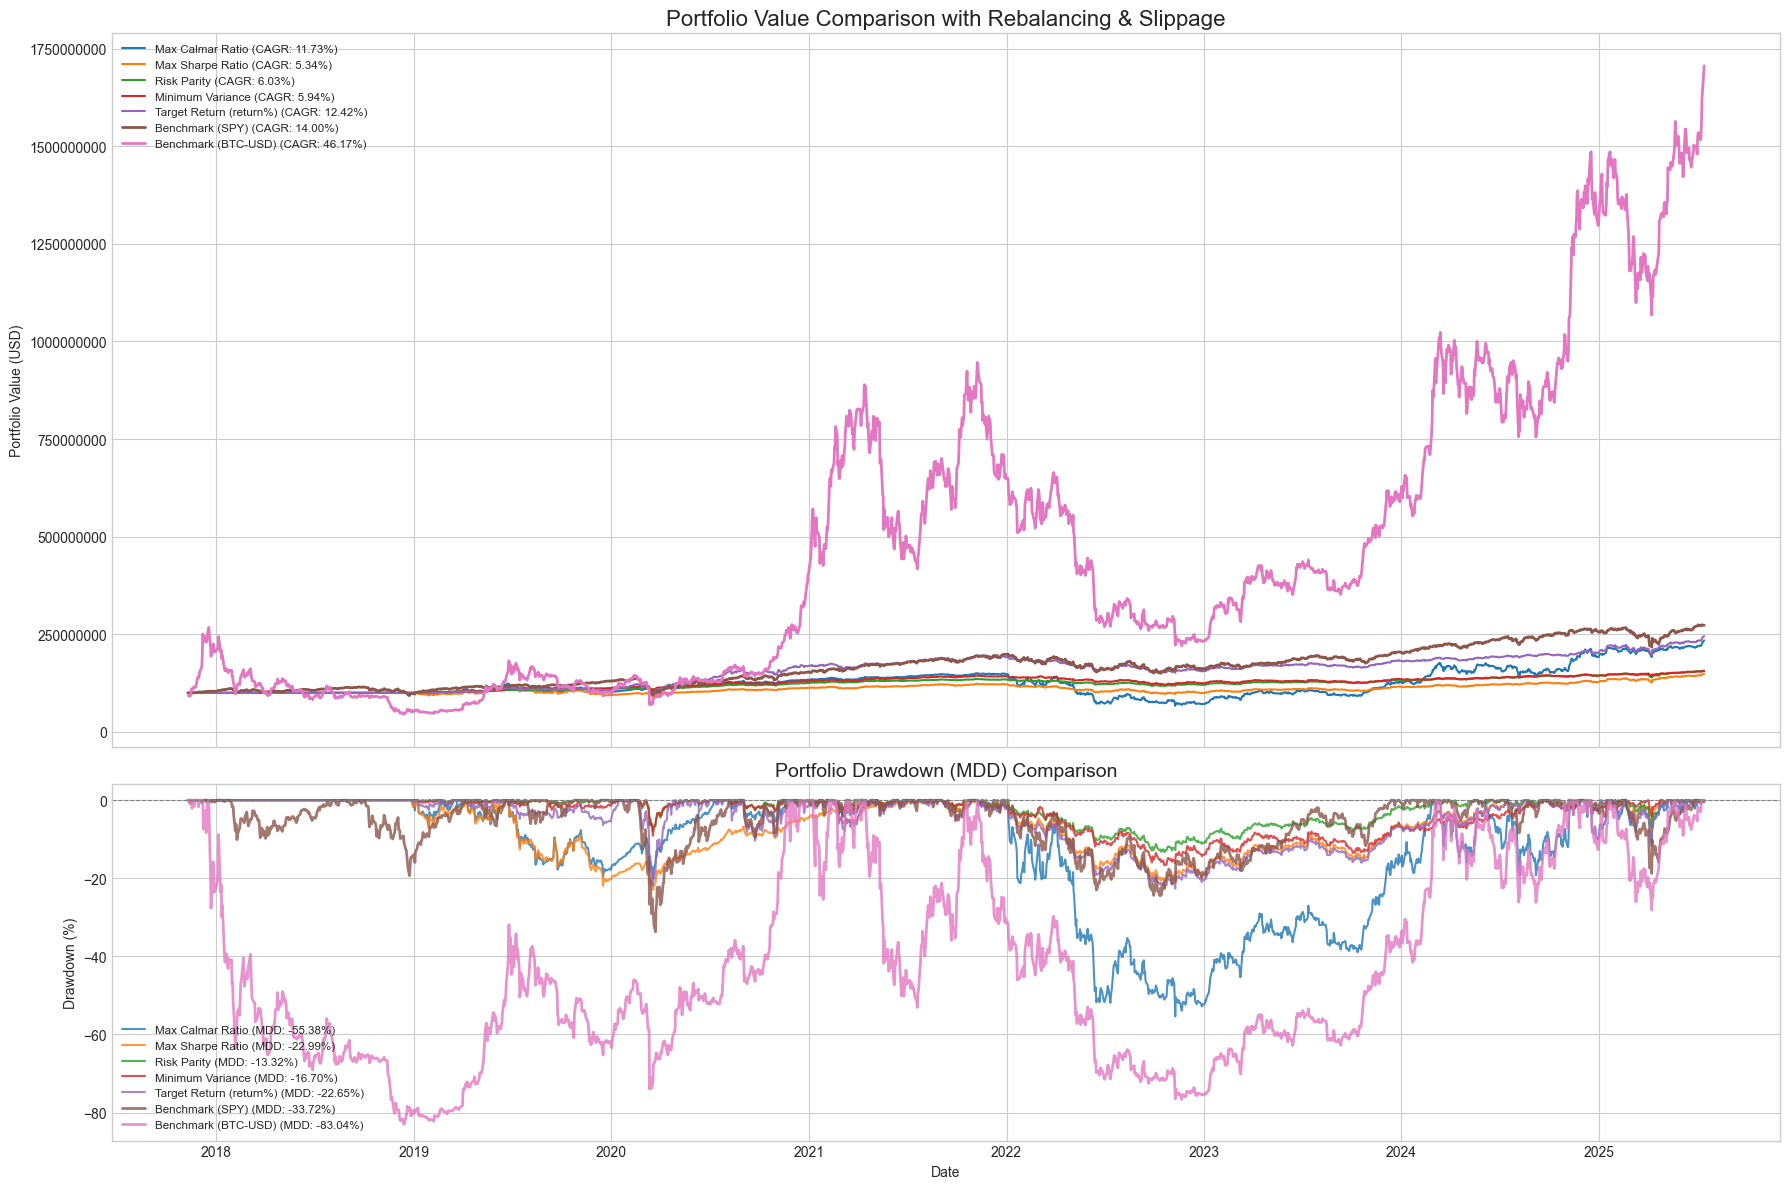

In [ ]:
# 6. 실행 파일 1 (최적화 비중 뽑아내는 것 까지)

import pandas as pd
import numpy as np
import config
from data_manager import DataManager
from portfolio_optimizer import PortfolioOptimizer
from backtester import DynamicBacktester
from visualizer import Visualizer
from utils import format_model_name
###test
# --- 1. 데이터 준비 ---
dm = DataManager()
stock_data = dm.get_data(config.STOCKS, config.START_DATE, config.END_DATE, save_path=config.RAW_DATA_PATH)

# --- 2. 전략별 백테스팅 실행 ---
portfolio_results = {}

def strategy_wrapper(prices, **params):
    """최적화 로직을 백테스터에 전달하기 위한 래퍼 함수"""
    returns = dm.calculate_returns(prices, 'daily')
    optimizer = PortfolioOptimizer(returns)
    
    # Risk Parity는 별도 처리
    if params.get('is_optimizer') is False:
        return optimizer.get_risk_parity_weights(returns)
        
    # 나머지 최적화 전략
    num_assets = len(prices.columns)
    bounds = tuple(((config.WEIGHT_CONSTRAINTS['min'], config.WEIGHT_CONSTRAINTS['max'])) for _ in range(num_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    target_return = params.get('target_return')
    
    if target_return is not None:
        constraints.append({'type': 'ineq', 'fun': lambda w: optimizer.calculate_metrics(w)['return'] - target_return})
        
    return optimizer.run_optimization(params['objective'], constraints=constraints, bounds=bounds)

# 활성화된 전략 실행
for name, params in config.STRATEGIES.items():
    if not params.get('enabled', False):
        continue
    
    model_name = format_model_name(name)
    print(f"\n--- '{model_name}' 모델 동적 백테스팅 시작 ---")
    
    backtester = DynamicBacktester(
        prices=stock_data,
        strategy_func=strategy_wrapper,
        strategy_params=params,
        initial_investment=config.INITIAL_INVESTMENT_USD,
        window=config.ROLLING_WINDOW_YEARS,
        frequency=config.REBALANCE_FREQUENCY,
        slippage=config.SLIPPAGE_PCT
    )
    portfolio_value = backtester.run()
    
    performance = DynamicBacktester.calculate_performance_metrics(portfolio_value, config.RISK_FREE_RATE_ANNUAL)
    portfolio_results[model_name] = {'value': portfolio_value, **performance}

# --- 3. 벤치마크 성과 계산 ---
benchmarks = {'SPY': 'SPY', 'BTC-USD': 'BTC-USD'}
for bm_name, bm_ticker in benchmarks.items():
    if bm_ticker in stock_data.columns:
        bm_price_data = stock_data[[bm_ticker]].dropna()
        bm_returns = bm_price_data.pct_change().dropna()
        portfolio_value = (config.INITIAL_INVESTMENT_USD * (1 + bm_returns).cumprod()).iloc[:, 0]
        performance = DynamicBacktester.calculate_performance_metrics(portfolio_value, config.RISK_FREE_RATE_ANNUAL)
        portfolio_results[f"Benchmark ({bm_name})"] = {'value': portfolio_value, **performance}

# --- 4. 최종 결과 요약 및 저장 ---
if portfolio_results:
    report_data = []
    print("\n\n--- 최종 성과 요약 ---")
    for name, metrics in portfolio_results.items():
        print(f"  - {name}: CAGR={metrics['CAGR']:.2%}, MDD={metrics['MDD']:.2%}, Sharpe={metrics['Sharpe Ratio']:.2f}, Calmar={metrics['Calmar Ratio']:.2f}")
        row = {k: v for k, v in metrics.items() if k not in ['value', 'drawdown_series']}
        row['Model'] = name
        report_data.append(row)
        
    report_df = pd.DataFrame(report_data).set_index('Model')
    report_df.to_csv(config.PERFORMANCE_REPORT_SAVE_PATH)
    print(f"\n상세 성과 보고서가 저장되었습니다: {config.PERFORMANCE_REPORT_SAVE_PATH}")
    display(report_df)

    # --- 5. 시각화 ---
    visualizer = Visualizer(portfolio_results)
    visualizer.plot_performance_comparison()
